# Charity Data ML

This is data webscrapped from Charitywatch.org. The data was already cleaned before being saved.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

Let's read in the data and look at the charity grades

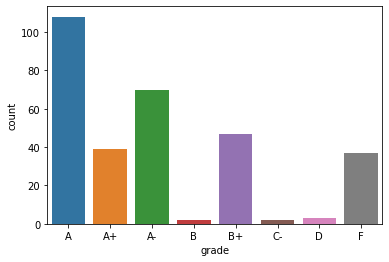

In [2]:
charData = pd.read_csv("data.csv",index_col=1).drop("Unnamed: 0",axis = 1)
sns.countplot(x = "grade", data = charData.sort_values("grade"));

A logistic regression would not be good here, since there are so many A's and the grades are in general heavily skewed toward the higher end.

"top rated" does not just mean "A" and "A+" grades

In [3]:
charData.loc[charData["topRated"] == 0,"grade"].unique()

array(['F', 'B', 'D', 'C-', 'A+', 'A'], dtype=object)

The "governance" factor is redundant

In [4]:
govTable = charData.loc[charData["governance"] == 1,['govA', 'govB', 'govC', 'govD', 'govE', 'govF', 'govG', 'govH', 'govI']]
govTableSum = govTable.sum(axis=1)
govTotal9Bool = govTableSum == 9
govTotal9Bool.sum() == charData.loc[charData["governance"] == 1].shape[0]

True

The "transparency" factor is redundant

In [5]:
(charData.loc[charData["transparency"] == 1,['transA', 'transB']].sum(axis=1) == 2).sum() == charData.loc[charData["transparency"] == 1].shape[0]

True

Prepare dataset for modeling

In [79]:
predictorMat = charData.drop(["topRated","governance","transparency"],axis = 1)
predictorMat["programPerc"] = predictorMat["programPerc"].str.replace("%","").astype(int)
predictorMat["cost100"] = predictorMat["cost100"].str.replace("$","",regex=False).astype(int)

#### PREDICT TOP RATED

Let's first see if we can predict "top rated"

Test,Train split

In [7]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(predictorMat, charData["topRated"], test_size=0.2, random_state=97)

Since these labels are created by human decisions, a decision tree should be able to do a good job at predicting

First model

In [8]:
X_train1a = X_train1[['transA', 'transB', 'govA', 'govB', 'govC', 'govD', 'govE', 'govF', 'govG', 'govH', 'govI', 'privacy']]
treeModel1a = DecisionTreeClassifier()
treeModel1a.fit(X_train1a,y_train1);

In [9]:
def performance(predictions,actual):
    nWrong = len(actual) - sum(predictions == actual)
    percRight = sum(predictions == actual) / len(actual) * 100
    return nWrong,percRight
performance(treeModel1a.predict(X_train1a),y_train1)

(1, 99.59349593495935)

We missed one. Let's try adding "tax status".

In [10]:
dummyTax = pd.get_dummies(X_train1["taxStatus"], drop_first=True)
X_train1b = pd.concat([dummyTax, X_train1a], axis=1)
treeModel1b = DecisionTreeClassifier()
treeModel1b.fit(X_train1b,y_train1)
performance(treeModel1b.predict(X_train1b),y_train1)

(1, 99.59349593495935)

We still missed one. Tax status doesn't seem to help. Let's use "Program Percentage" (amount spent on programs
relative to overhead)

In [12]:
X_train1c = pd.concat([X_train1["programPerc"], X_train1a], axis=1)
treeModel1c = DecisionTreeClassifier()
treeModel1c.fit(X_train1c,y_train1)
performance(treeModel1c.predict(X_train1c),y_train1)

(0, 100.0)

We correctly predicted all labels. Let's look at the tree.

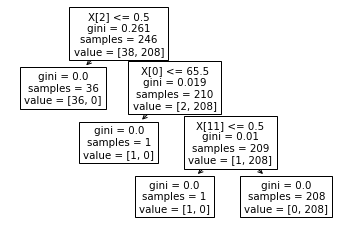

In [13]:
plot_tree(treeModel1c);

It looks like the only factors we really need are "programPerc","transB", and "govI". transB is probably more indicative of overall transparency, and govI is probably more indicative of overall governance.

In [14]:
X_train1d = X_train1c[["programPerc","transB","govI"]]
treeModel1d = DecisionTreeClassifier()
treeModel1d.fit(X_train1d,y_train1);

Let's now test the model

In [16]:
X_test1 = X_test1[["programPerc",'transB', 'govI']]
performance(treeModel1d.predict(X_test1), y_test1)

(0, 100.0)

It looks like our model was successfully able to label the test set

#### PREDICT GRADE

Let's now try to predict grade. Since we were able to predict "Top Rated", it is a redundant factor, so we will not be adding it back to the dataframe.

In [80]:
predictorMat = predictorMat.drop("grade", axis = 1)

Test,Train split

In [19]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(predictorMat, charData["grade"], test_size=0.2, random_state=94)

Let's use a similar model as before to predict grade

In [20]:
X_train2a = X_train2[["programPerc",'transA', 'transB', 'govA', 'govB', 'govC', 'govD', 'govE', 'govF', 'govG', 'govH', 'govI', 'privacy']]
treeModel2a = DecisionTreeClassifier()
treeModel2a.fit(X_train2a,y_train2)
performance(treeModel2a.predict(X_train2a), y_train2)

(31, 87.39837398373984)

We failed to correctly label 31 charities. Let's add "cost100" (amount spent to raise
$100 of contributions)

In [21]:
X_train2b = pd.concat([X_train2["cost100"],X_train2a], axis=1)
treeModel2b = DecisionTreeClassifier()
treeModel2b.fit(X_train2b,y_train2)
performance(treeModel2b.predict(X_train2b), y_train2)

(0, 100.0)

We correctly predicted all labels. Let's look at the tree.

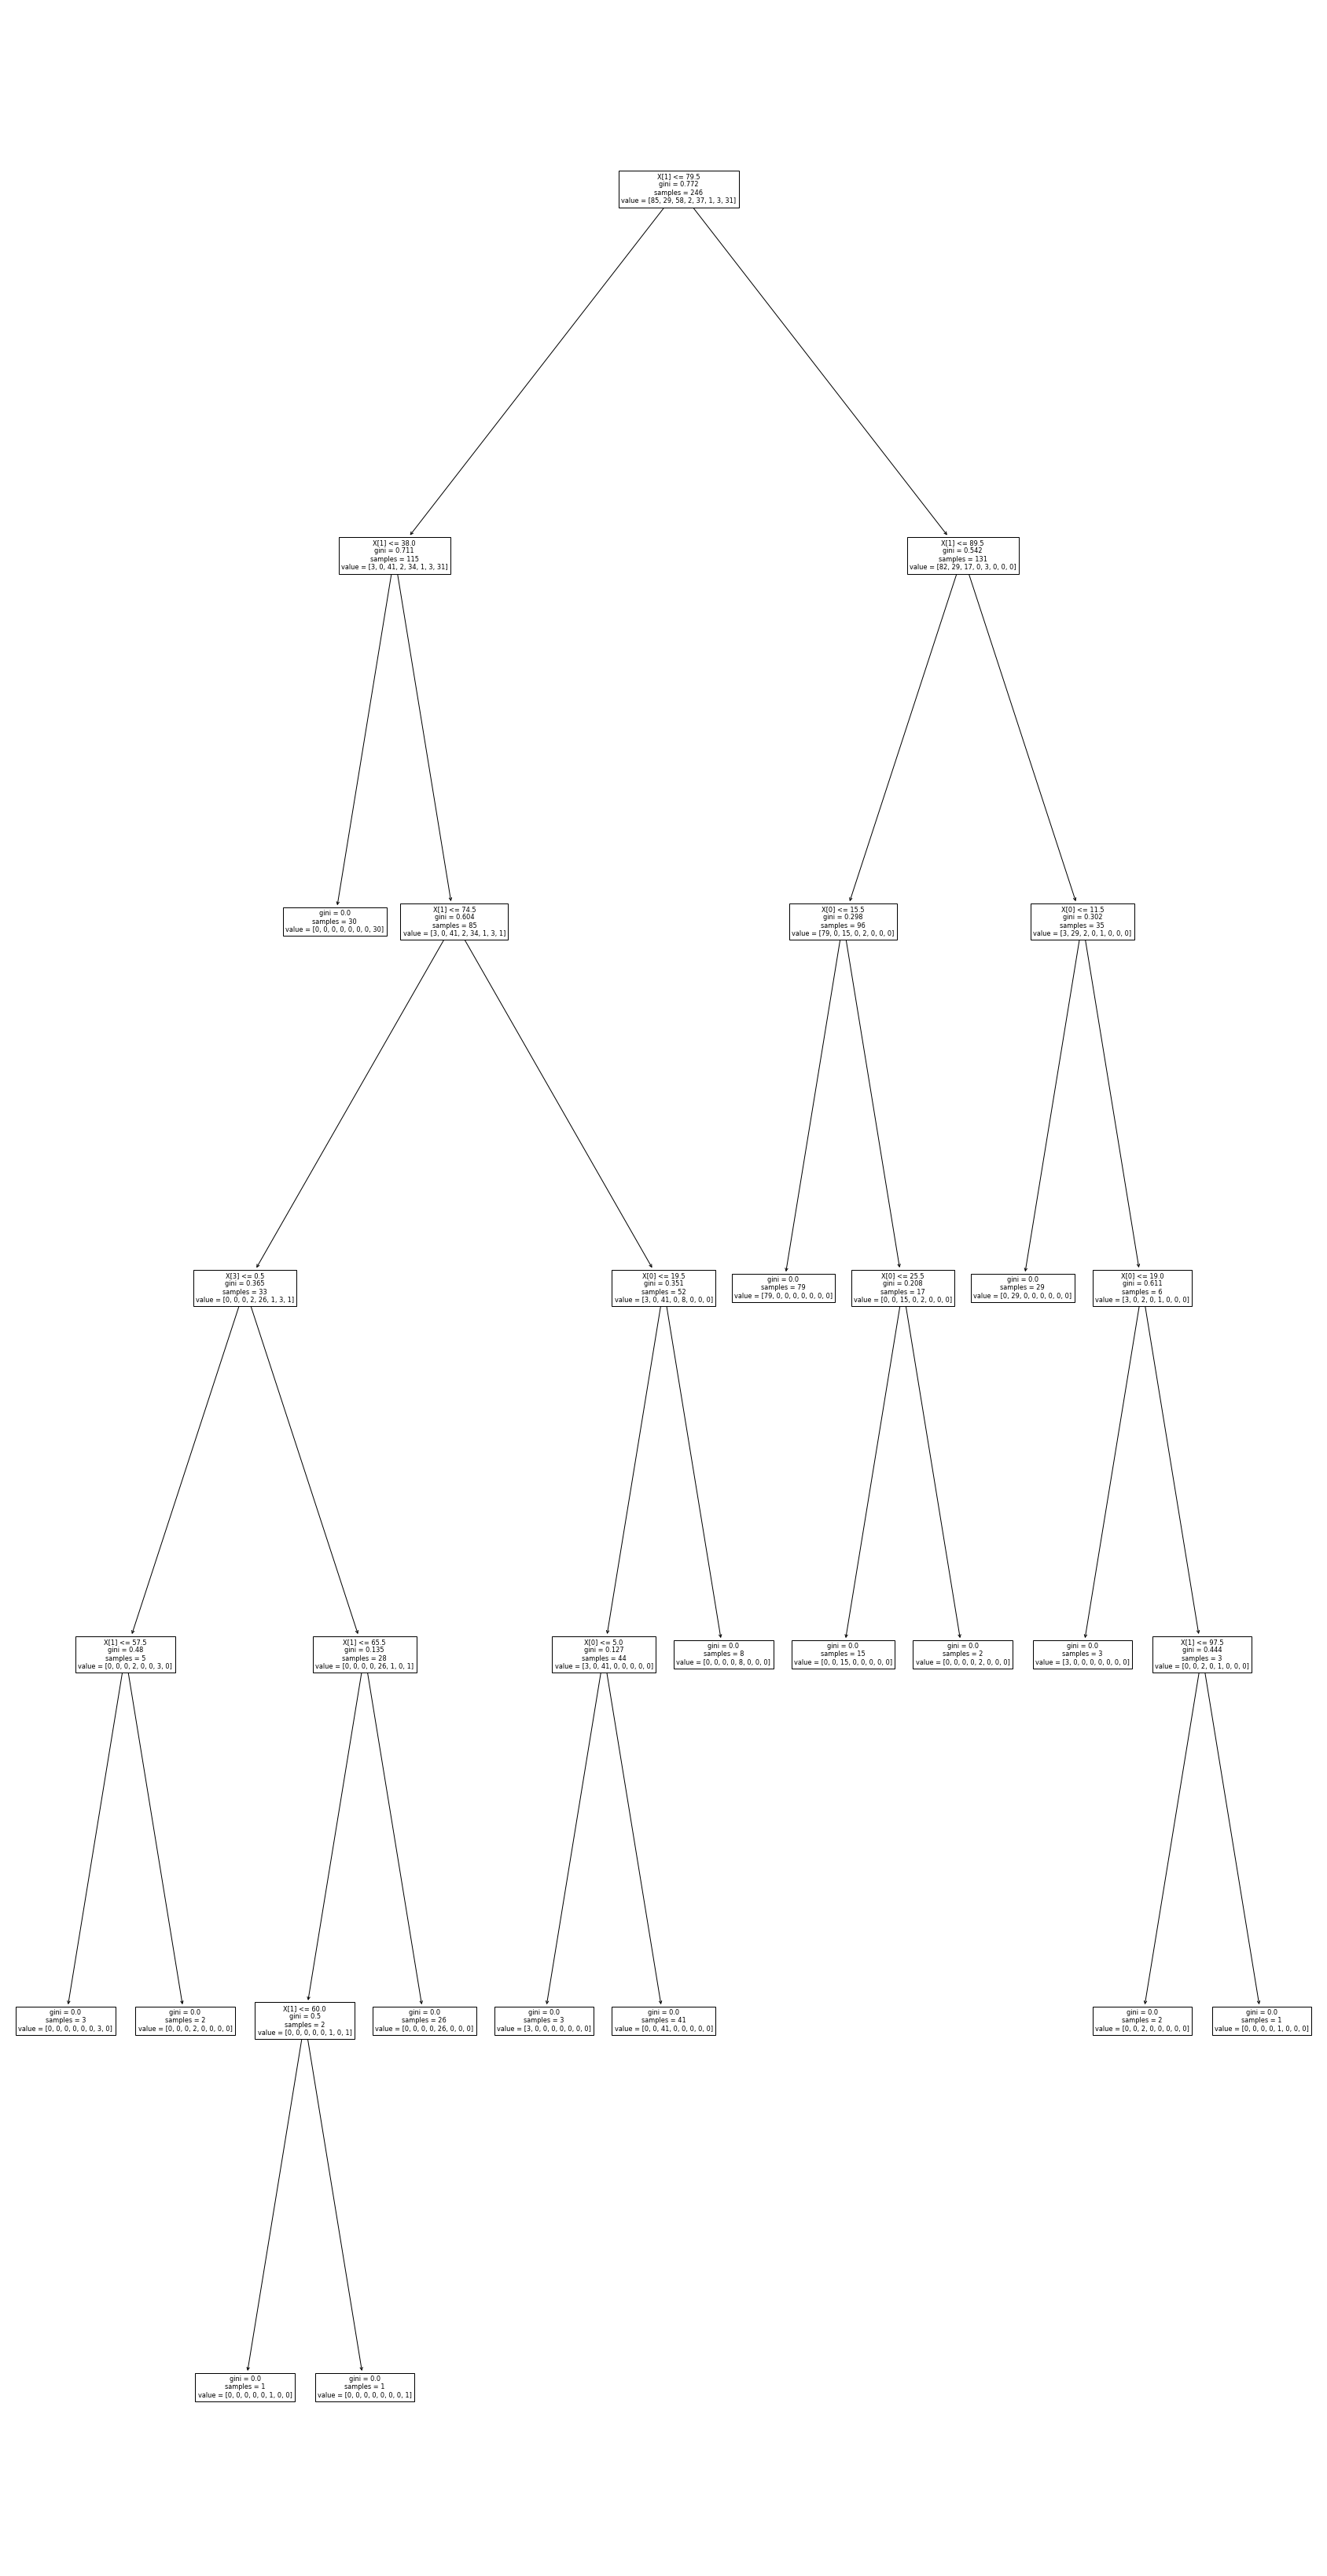

In [22]:
plt.figure(figsize=(30, 60))
plot_tree(treeModel2b);

It looks like the only factors we really need are "cost100, "programPerc", and "transB".

In [23]:
X_train2c = X_train2b[["cost100","programPerc","transB"]]
treeModel2c = DecisionTreeClassifier()
treeModel2c.fit(X_train2c,y_train2);

Let's now test the model

In [24]:
X_test2 = X_test2[["cost100","programPerc",'transB']] 
performance(treeModel2c.predict(X_test2), y_test2)

(4, 93.54838709677419)

It looks like we weren't able to correctly label 4 charities. Fortunately, we actually know how these grades are chosen. The criteria can be found here (https://www.charitywatch.org/our-charity-rating-process). It seems like charity watch only uses Program Percentage and Cost to Raise 100.

#### Predict Grade Using Criteria

Test,Train split

In [25]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(predictorMat, charData["grade"], test_size=0.2, random_state=99)

Let's train on only "programPerc" and "cost100".

In [26]:
X_train3a = X_train3[["programPerc","cost100"]]
treeModel3a = DecisionTreeClassifier()
treeModel3a.fit(X_train3a,y_train3)
performance(treeModel3a.predict(X_train3a), y_train3)

(0, 100.0)

We correctly predicted all labels. Let's now test the model

In [27]:
X_test3a = X_test3[["programPerc","cost100"]]
performance(treeModel3a.predict(X_test3a), y_test3)

(3, 95.16129032258065)

It looks like we performed slightly better, but we should have essentially done perfectly well. Let's look at what we got wrong.

In [29]:
def checkTable(dataset,predicted,Y):
    actualLabels = Y.loc[predicted != Y].rename("Actual")
    predictedLabels = pd.DataFrame(predicted[predicted != Y], index = actualLabels.index, columns = ["Predicted"])
    predictors = dataset.loc[predicted != Y,["programPerc","cost100"]]
    return pd.concat([actualLabels,predictedLabels,predictors],axis=1)
checkTable(X_test3,treeModel3a.predict(X_test3a),y_test3)

,Actual,Predicted,programPerc,cost100
name,,,,
Amazon Conservation Team,A,A-,77,4
EngenderHealth,A,A-,76,2
HealthRight International,A,A-,76,1


Interestingly, the decision tree actually predicted these grades correctly in reference to Program Percentage. "A-" grades fall between 75-79%, but "A+" falls between $0-4 for Cost to Raise 100. Those at charity watch probably split the difference and gave them a grade of "A".

This happens because decision trees can only use one factor at a time to make decisions. Let's see if training on each feature and then weighing them will solve this problem. We'll use a random forest in order to avoid overfitting a bit.

In [30]:
gradesDict = {"F":0,"D":1,"C-":2,"C":3,"C+":4,"B-":5,"B":6,"B+":7,"A-":8,"A":9,"A+":10}
charData = charData.replace(gradesDict)
X_train4, X_test4, y_train4, y_test4 = train_test_split(predictorMat, charData["grade"], test_size=0.2, random_state=86)
ppModel1 = RandomForestClassifier(max_samples = .9)
ppModel1.fit(X_train4[["programPerc"]],y_train4)
c1Model1 = RandomForestClassifier(max_samples = .9)
c1Model1.fit(X_train4[["cost100"]],y_train4);

number incorrect for program percent model

In [31]:
performance(ppModel1.predict(X_train4[["programPerc"]]), y_train4)

(38, 84.5528455284553)

number incorrect for cost to raise 100 model

In [32]:
performance(c1Model1.predict(X_train4[["cost100"]]), y_train4)

(77, 68.69918699186992)

Turn the predictions into a matrix, find the pseudoinverse and multiply by the actual labels in order to find the weights.

In [35]:
predMat1 = np.array([ppModel1.predict(X_train4[["programPerc"]]),c1Model1.predict(X_train4[["cost100"]])]).T
weights1 = y_train4 @ np.linalg.pinv(predMat1).T
predicted1 = (np.rint(predMat1 @ weights1)).astype(int)
performance(predicted1, y_train4)

(35, 85.77235772357723)

It looks like the simpler model does a much better job. However, our more complex model isn't far off from the correct labels.

In [36]:
checkTable(X_train4, predicted1, y_train4)

,Actual,Predicted,programPerc,cost100
name,,,,
American Red Cross,8,9,90,24
Ploughshares Fund,8,9,81,18
Coalition for the Homeless,8,9,84,17
Southern Poverty Law Center,0,2,64,15
Project Concern International (PCI),7,8,87,28
Project HOPE,7,8,77,27
National Jewish Health,7,8,88,27
American Forests,8,9,81,16
Environmental Defense Fund,7,8,77,20


Although we didn't perform so well on the training data, let's see how we perform on the test data.

In [39]:
predMatTest1 = np.array([ppModel1.predict(X_test4[["programPerc"]]),c1Model1.predict(X_test4[["cost100"]])]).T
predictedTest1 = (np.rint(predMatTest1 @ weights1)).astype(int)
performance(predictedTest1, y_test4)

(8, 87.09677419354838)

Let's look at where we went wrong.

In [40]:
checkTable(X_test4, predictedTest1, y_test4)

,Actual,Predicted,programPerc,cost100
name,,,,
Autism Society of America (National Office) & Foundation,8,9,82,16
World Vision,8,9,81,16
MAP International,7,8,76,21
Bat Conservation International,7,8,75,26
Give Kids the World,7,8,80,30
Save the Children,8,9,86,16
Trout Unlimited (National Office),8,9,86,17
American Kidney Fund,10,8,97,2


We made a very clear error on "American Kidney Fund". This should clearly be an A+. The flaw here is that this more complex model actually does not simulate human decision making. This is because we've found the weights using the entire matrix, but factors only need to be weighted when the labels disagree. Let's see if this insight improves our model.

In [44]:
ppDF1 = pd.DataFrame(ppModel1.predict(X_train4[["programPerc"]]), index = X_train4.index, columns = ["ppModel"])
c1DF1 = pd.DataFrame(c1Model1.predict(X_train4[["cost100"]]), index = X_train4.index, columns = ["c1Model"])
predMat2 = pd.concat([ppDF1,c1DF1],axis=1)
disagreeMat1 = predMat2.loc[predMat2["ppModel"] != predMat2["c1Model"]]
weights2 = y_train4.loc[predMat2["ppModel"] != predMat2["c1Model"]] @ np.linalg.pinv(disagreeMat1).T
predicted2 = pd.concat([predMat2.loc[predMat2["ppModel"] == predMat2["c1Model"],"ppModel"],(np.rint(disagreeMat1 @ weights2)).astype(int)]).rename("grade")
predicted2 = predicted2.sort_index()
y_train4 = y_train4.sort_index()
performance(predicted2, y_train4)

(23, 90.65040650406505)

We've improved model performance. Let's see what we got wrong.

In [45]:
def checkTablev2(dataset,predicted,Y):
    actualLabels = Y.loc[predicted != Y].rename("Actual")
    predictedLabels = predicted[predicted != Y].rename("Predicted")
    predictors = dataset.loc[predicted != Y,["programPerc","cost100"]]
    return pd.concat([actualLabels,predictedLabels,predictors],axis=1)

checkTablev2(X_train4, predicted2, y_train4)

,Actual,Predicted,programPerc,cost100
name,,,,
Amazon Conservation Team,9,8,77,4
American Red Cross,8,9,90,24
Big Brothers/Big Sisters of America (National Office),10,9,91,7
Catholic Relief Services,10,9,91,10
Christian Advocates Serving Evangelism,6,7,71,27
Comic Relief,10,9,90,8
DonorsChoose.org,10,9,94,5
Elizabeth Glaser Pediatric AIDS Foundation,10,9,91,9
EngenderHealth,9,8,76,2


Let's try our test data.

In [46]:
ppDFtest1 = pd.DataFrame(ppModel1.predict(X_test4[["programPerc"]]), index = X_test4.index, columns = ["ppModel"])
c1DFtest1 = pd.DataFrame(c1Model1.predict(X_test4[["cost100"]]), index = X_test4.index, columns = ["c1Model"])
predMatTest2 = pd.concat([ppDFtest1,c1DFtest1],axis=1)
disagreeMatTest1 = predMatTest2.loc[predMatTest2["ppModel"] != predMatTest2["c1Model"]]
predictedTest2 = pd.concat([predMatTest2.loc[predMatTest2["ppModel"] == predMatTest2["c1Model"],"ppModel"],(np.rint(disagreeMatTest1 @ weights2)).astype(int)]).rename("grade")
predictedTest2 = predictedTest2.sort_index()
y_test4 = y_test4.sort_index()
performance(predictedTest2, y_test4)

(5, 91.93548387096774)

Let's look at where we went wrong.

In [47]:
checkTablev2(X_test4, predictedTest2, y_test4)

,Actual,Predicted,programPerc,cost100
name,,,,
American Kidney Fund,10,8,97,2
Concerns of Police Survivors (COPS),10,9,90,7
Give Kids the World,7,8,80,30
Hearing Health Foundation,10,9,91,7
Prevent Child Abuse America (National Office),10,9,90,6


We are still not able to correctly label "American Kidney Fund". It seems like the simpler model performed much better. However, it also seems like the simpler model overfit to the data. SPLC is given an F (0), but it doesn't actually fall into any of the criteria for getting an F. An "F" means having a program percentage of < 35% and a cost to raise \\$100 of > \\$60. SPLC should actually be a C+ (4) by program percentage or an A- (8) by cost to raise \\$100. The simpler model should not have correctly predicted this label.

In [48]:
SPLC = checkTablev2(X_train4, predicted2, y_train4)
SPLC[SPLC.index == "Southern Poverty Law Center"]

,Actual,Predicted,programPerc,cost100
name,,,,
Southern Poverty Law Center,0,2,64,15


Finally, since we have the actual levels of each feature used to give grades, let's see if we can predict using these levels.

#### Predicting using levels of features

In [83]:
ppBins = pd.IntervalIndex.from_tuples([(0,35),(36,49),(50,55),(56,60),(61,64),(65,67),(68,71),(72,74),(75,79),(80,89),(90,100)],closed = "both")
c1Bins = pd.IntervalIndex.from_tuples([(0,4),(5,11),(12,15),(16,19),(20,26),(27,30),(31,33),(34,37),(38,40),(41,59),(60,100)],closed = "both")
predictorMat["catProgramPerc"] = pd.cut(predictorMat["programPerc"], bins = ppBins).cat.rename_categories([0,1,2,3,4,5,6,7,8,9,10])
predictorMat["catCost100"] = pd.cut(predictorMat["cost100"], bins = c1Bins).cat.rename_categories([10,9,8,7,6,5,4,3,2,1,0])

In [84]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(predictorMat, charData["grade"], test_size=0.2, random_state=78)
treeModel5 = DecisionTreeClassifier()
treeModel5.fit(X_train5[["catProgramPerc","catCost100"]],y_train5)
performance(treeModel5.predict(X_train5[["catProgramPerc","catCost100"]]), y_train5)

(0, 100.0)

We fit the training data perfectly. Now, let's see how we do on test data.

In [85]:
performance(treeModel5.predict(X_test5[["catProgramPerc","catCost100"]]), y_test5)

(4, 93.54838709677419)

Once again, it looks like our original simple model works best. Let's look at where we went wrong.

In [86]:
checkTable(X_test5, treeModel5.predict(X_test5[["catProgramPerc","catCost100"]]), y_test5)

,Actual,Predicted,programPerc,cost100
name,,,,
NARAL Pro-Choice America (National Office),2,1,55,34
Southern Poverty Law Center,0,7,64,15
Christian Advocates Serving Evangelism,6,7,71,27
Planned Parenthood Federation of America,6,7,70,23


Besides NARAL, the predicted labels actually fall well along the criteria that charity watch uses. Let's try the more complex model one last time with this intervaled data. We'll use a random forest to try to prevent overfitting a bit.

In [104]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(predictorMat, charData["grade"], test_size=0.2, random_state=86)
ppModel2 = RandomForestClassifier(max_samples = .9)
ppModel2.fit(X_train6[["catProgramPerc"]],y_train6)
c1Model2 = RandomForestClassifier(max_samples = .9)
c1Model2.fit(X_train6[["catCost100"]],y_train6);

Look at program percentage model

In [105]:
performance(ppModel2.predict(X_train6[["catProgramPerc"]]), y_train6)

(39, 84.14634146341463)

Look at cost to raise 100 model

In [106]:
performance(c1Model2.predict(X_train6[["catCost100"]]), y_train6)

(78, 68.29268292682927)

This version of the more complex model is about as good as the previous one

In [107]:
ppDF2 = pd.DataFrame(ppModel2.predict(X_train6[["catProgramPerc"]]), index = X_train6.index, columns = ["ppModel"])
c1DF2 = pd.DataFrame(c1Model2.predict(X_train6[["catCost100"]]), index = X_train6.index, columns = ["c1Model"])
predMat3 = pd.concat([ppDF2,c1DF2],axis=1)
disagreeMat2 = predMat3.loc[predMat3["ppModel"] != predMat3["c1Model"]]
weights3 = y_train6.loc[predMat3["ppModel"] != predMat3["c1Model"]] @ np.linalg.pinv(disagreeMat2).T
predicted3 = pd.concat([predMat3.loc[predMat3["ppModel"] == predMat3["c1Model"],"ppModel"],(np.rint(disagreeMat2 @ weights3)).astype(int)]).rename("grade")
predicted3 = predicted3.sort_index()
y_train6 = y_train6.sort_index()
performance(predicted3, y_train6)

(23, 90.65040650406505)

Looking at where we failed, it looks like we have many of the same culprits.

In [45]:
checkTablev2(X_train6, predicted3, y_train6)

,Actual,Predicted,programPerc,cost100
name,,,,
Amazon Conservation Team,9,8,77%,$4
American Red Cross,8,9,90%,$24
Big Brothers/Big Sisters of America (National Office),10,9,91%,$7
Catholic Relief Services,10,9,91%,$10
Christian Advocates Serving Evangelism,6,7,71%,$27
Comic Relief,10,9,90%,$8
DonorsChoose.org,10,9,94%,$5
Elizabeth Glaser Pediatric AIDS Foundation,10,9,91%,$9
EngenderHealth,9,8,76%,$2


### Summary

We started by trying to predict the category of "Top Rated". We were able to label that perfectly. We then tried using decision trees in various ways to correctly label the charities with grades, but we were not able to perfectly do so. In the end, it seems like the simplest model, which was a decision tree using both "program percentage" and "cost to raise $100" as continuous variables, was able to perform the best. However, it may have overfit to the training data, since there were some charities it was able to predict but should not have been able to do so.